Loading all the neccesary header files 

In [25]:
#import face_recognition
import argparse
import pickle
import cv2
import os
import numpy as np
from imutils import build_montages
from matplotlib import pyplot as plt
import matplotlib.pyplot as mpld3
import pandas as pd
from collections import Counter
from sklearn import metrics
from pylab import *
from sklearn.cluster import DBSCAN
from sklearn.model_selection import GridSearchCV
from kneed import DataGenerator, KneeLocator
import sklearn
import hdbscan
from scipy.spatial import distance
from scipy.cluster import hierarchy
from s_dbw import S_Dbw
%matplotlib inline

### Loading the filepaths for the datasets 

In [2]:
def loadFilePaths(image_directory):
    
    files=os.listdir(image_directory)
    files_path=[os.path.join(image_directory,file) for file in files ]
    return files_path


In [3]:
ideology_files_path=loadFilePaths('ideology_image_dataset/')
muslim_files_path=loadFilePaths('muslim_image_dataset/')
len(ideology_files_path),len(muslim_files_path)

(2942, 242)

### Loading the pickle files, we are clustering based on the faces and  a image can contain the multiple faces 

In [4]:
with open('ideology_data_face_Embeddings.pickle','rb') as f:
    ideology_face_data=pickle.load(f)

with open('muslim_data_face_Embeddings.pickle','rb') as f:
    muslim_face_data=pickle.load(f)

In [5]:
ideology_face_data_updated=[]
muslim_face_data_updated=[]
for element in ideology_face_data:
    ideology_face_data_updated.extend(element)

for element in muslim_face_data:
    muslim_face_data_updated.extend(element)

In [6]:
len(ideology_face_data_updated),len(muslim_face_data_updated)

(3532, 302)

In [7]:
ideology_face_data_updated[0].keys()

dict_keys(['image-path', 'face-location', 'face-encodings'])

### Making the data for the clustering model

In [8]:
def getEncodings(data):
    train_data=np.array(data)
    encodings = [d["face-encodings"] for d in train_data]
    return encodings

In [9]:
ideology_encodings=getEncodings(ideology_face_data_updated)
muslim_encodings=getEncodings(muslim_face_data_updated)
len(ideology_encodings),len(muslim_encodings)

(3532, 302)

### Visualization the detected faces in the image

In [23]:
def showImage(file_path,coordinates):
    #print(coordinates)
    top=coordinates[0]
    right=coordinates[1]
    bottom=coordinates[2]
    left=coordinates[3]
    image = cv2.imread(file_path)
   # print(image.shape)
    #height,width, channels
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    cv2.rectangle(image, (left, top), (right, bottom), (0, 255, 0), 2)
    plt.imshow(image)
    plt.axis("off")
    plt.show()
    #cv2.rectangle(image, (left, top), (right, bottom), (0, 255, 0), 2)
    

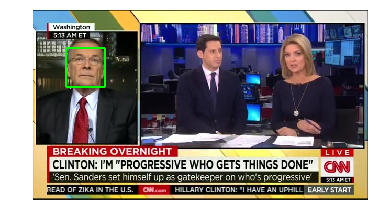

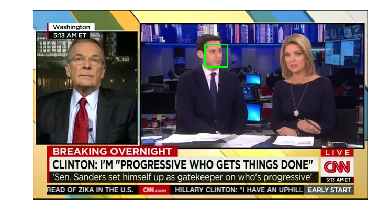

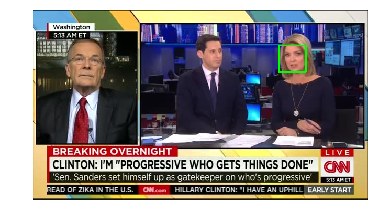

In [24]:
showImage('ideology_image_dataset/clip_2805.jpg',ideology_face_data[9][0]['face-location'])
showImage('ideology_image_dataset/clip_2805.jpg',ideology_face_data[9][1]['face-location'])
showImage('ideology_image_dataset/clip_2805.jpg',ideology_face_data[9][2]['face-location'])


### Implementing the clustering models

In [10]:
def cv_silhouette_scorer(estimator, X):
    estimator.fit(X)
    try:
        cluster_labels = estimator.labels_
    except Exception as e:
      #  print(e,estimator)
        cluster_labels=estimator.predict(X)
    num_labels = len(set(cluster_labels))
    num_samples = len(X)
    if num_labels == 1 or num_labels == num_samples or num_labels<=2:
        return -1
    else:
        return metrics.silhouette_score(X, cluster_labels)



In [11]:
def evaluation_Score(features,y_pred,output_df,model):
    try:
        
        num_labels=len(set(y_pred))
        total_samples=len(y_pred)
        print("labels",num_labels)
        if(num_labels==1 or num_labels==total_samples):
            output_df.loc[model,'silhouette'] =-1
            output_df.loc[model,'calinski'] =-1
            output_df.loc[model,'davies'] =-1
            
        else:
            output_df.loc[model,'silhouette'] =metrics.silhouette_score(features,y_pred)
            output_df.loc[model,'calinski'] =metrics.calinski_harabasz_score(features, y_pred)
            output_df.loc[model,'davies'] =metrics.davies_bouldin_score(features,y_pred)
            features = np.array(features)
            score = S_Dbw(features,y_pred, centers_id=None, method='Tong', alg_noise='bind',
                            centr='mean', nearest_centr=True, metric='euclidean')
            print("Score",score)
            output_df.loc[model,'S_Dbw']=score
    

    except Exception as e:
        print(e)
        pass
        
    return output_df
       

In [12]:
def getEpsilon(train_data):
    neigh = sklearn.neighbors.NearestNeighbors(n_neighbors=2)
    nbrs = neigh.fit(train_data)
    distances, indices = nbrs.kneighbors(train_data)
    distances = np.sort(distances, axis=0)
    distances = distances[:,1]
    y=distances
    x=list(np.arange(0,len(distances)))
    epsilons=[]
    for s in range(10,120,25):
        try:
            kneedle = KneeLocator(x,y,S=s, curve='convex', direction='increasing')
            epsilon=kneedle.all_elbows_y[0]
            if(len(epsilons)>=1 and epsilons[-1]-epsilon<=0.001):
                print(" ")
                
            else:    
                epsilons.append(epsilon)
        
        except Exception as e:
            print(e)
            if(len(epsilons)>=1):
                epsilons.append(epsilons[-1]+s/10)
            else:
                epsilons.append(s/10)
    
    epsilons.append(0.6)
    epsilons.append(0.5)
    epsilons.append(0.8)
        
    print(epsilons)
 
    return epsilons

In [13]:
def runGridSearch(estimator,params_dict,train_data):
    
    cv = [(slice(None), slice(None))]
    gs = GridSearchCV(estimator=estimator, param_grid=params_dict, scoring=cv_silhouette_scorer, cv=cv, n_jobs=-1)
    gs.fit(train_data)
  #  print("Grid search",gs.cv_results_)
    try:
        predicted_labels= gs.best_estimator_.labels_
    except:
        predicted_labels=gs.predict(train_data)
    
    
    return predicted_labels

In [14]:
def dbscanModel(encodings):
    print("Running DBSCAN")
    clt = DBSCAN(metric="euclidean", n_jobs=-1)
    clt.fit(encodings)
    predicted_labels=clt.labels_
    unique_labels=np.unique(predicted_labels)
    print("Total unique labels ",len(unique_labels))
    return predicted_labels

## Running for ideology

### Running for the DBSCAN without gridSearch

In [15]:
predicted_labels1=dbscanModel(ideology_encodings)

output_df = pd.DataFrame(index=['DBSCAN-withoutGrid','DBSCAN-GridSearch'],columns=['n_clusters','silhouette','calinski','davies',
                                                                                   'S_Dbw'])
evaluation_Score(ideology_encodings,predicted_labels1,output_df,'DBSCAN-withoutGrid')    
if(set(predicted_labels1).issuperset({-1})):
        n_clustersLen=len(set(predicted_labels1))-1
else:
        n_clustersLen=len(set(predicted_labels1))
output_df.loc['DBSCAN-withoutGrid']['n_clusters']=n_clustersLen
output_df

Running DBSCAN
Total unique labels  97
labels 97
Score 0.5971973877348796


,n_clusters,silhouette,calinski,davies,S_Dbw
DBSCAN-withoutGrid,96,-0.0360036,12.5656,1.78845,0.597197
DBSCAN-GridSearch,NaN,NaN,NaN,NaN,NaN


# Running for DBSCAN with Grid Search

In [16]:
#epsilons=getEpsilon(ideology_encodings)
params_dict = {'eps':[0.3,0.4,0.5,0.6,0.7],'min_samples':[5],'metric':['euclidean','manhattan','mahalanobis', 'minkowski']}
predicted_labels2=runGridSearch(sklearn.cluster.DBSCAN(),params_dict,ideology_encodings)
evaluation_Score(ideology_encodings,predicted_labels2,output_df,'DBSCAN-GridSearch')
if(set(predicted_labels2).issuperset({-1})):
    n_clustersLen=len(set(predicted_labels2))-1
else:
    n_clustersLen=len(set(predicted_labels2))
output_df.loc['DBSCAN-GridSearch','n_clusters']=n_clustersLen

labels 116
Score 0.6942229654459516


In [17]:
output_df

,n_clusters,silhouette,calinski,davies,S_Dbw
DBSCAN-withoutGrid,96,-0.0360036,12.5656,1.78845,0.597197
DBSCAN-GridSearch,115,0.0246545,15.8596,1.52634,0.694223


### Saving the predicted labels into a npy file , the clustered faces will be visualize in the next notebook names bio-metric-results


In [19]:
np.save('bio-metric-predicted-dbscanwithoutGrid-labels.npy',np.array(predicted_labels1))
np.save('bio-metric-predicted-dbscanwithGrid-labels.npy',np.array(predicted_labels2))
